# Contextual Bandits Agent with Policy Gradient Method (Stochastic) in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from main import stochastic_training_notebook
from Environment import ScoreFunction

In [2]:
learning_rate_theta = 1e-4
learning_rate_wv = 1e-4
memory_size = 16
batch_size = 16
training_episodes = 300000
decay_rate = 0
beta1 = 0.9
beta2 = 0.9999
# Algorithm: adam, momentum, regular
algorithm = 'regular'
learning_std = False
fixed_std = 1
# Bucket parameters
pr_red_ball_red_bucket = 2/3
pr_red_ball_blue_bucket = 1/3
prior_red_list = [3/4, 1/4]
prior_red = 1/2
agent_num=1
action_num=1
score_func = ScoreFunction.LOG

agent_list = stochastic_training_notebook(learning_rate_theta, learning_rate_wv,
                                 memory_size, batch_size, training_episodes,
                                 decay_rate, beta1, beta2, algorithm, learning_std,
                                 fixed_std, pr_red_ball_red_bucket, pr_red_ball_blue_bucket,
                                 prior_red_list, agent_num, action_num, score_func)

  0%|          | 0/300000 [00:00<?, ?it/s]

agent0
learning_rate_theta= 0.0001  learning_rate_wv= 0.0001
memory_size= 16  standard deviation= 1
Updating weights with regular algorithm.


In [3]:
reward_history_df = pd.DataFrame(agent_list[0].reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
report_history_df = pd.DataFrame(agent_list[0].report_history_list, columns=['report', 'mean', 'std', 'signal'])
grad_mean_history_df = pd.DataFrame(agent_list[0].mean_gradients_history_list,
                                            columns=['red_ball', 'blue_ball', 'prior'])
mean_weights_history_df = pd.DataFrame(agent_list[0].mean_weights_history_list,
                                               columns=['red_weight', 'blue_weight', 'prior_weight'])

# reward_history_df2 = pd.DataFrame(agent2.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
# report_history_df2 = pd.DataFrame(agent2.report_history_list, columns=['report', 'mean', 'std', 'signal'])
# grad_mean_history_df2 = pd.DataFrame(agent2.mean_gradients_history_list,
#                                             columns=['red_ball', 'blue_ball', 'prior'])
# mean_weights_history_df2 = pd.DataFrame(agent2.mean_weights_history_list,
#                                                columns=['red_weight', 'blue_weight', 'prior_weight'])

# reward_history_df3 = pd.DataFrame(agent3.reward_history_list, columns=['signal', 'prior_red', 'actual_reward', 'estimated_average_reward'])
# report_history_df3 = pd.DataFrame(agent3.report_history_list, columns=['report', 'mean', 'std', 'signal'])
# grad_mean_history_df3 = pd.DataFrame(agent3.mean_gradients_history_list,
#                                             columns=['red_ball', 'blue_ball', 'prior'])
# mean_weights_history_df3 = pd.DataFrame(agent3.mean_weights_history_list,
#                                                columns=['red_weight', 'blue_weight', 'prior_weight'])

In [4]:
reward_history_df.groupby('signal').mean()

,prior_red,actual_reward,estimated_average_reward
signal,,,
blue,-0.187307,-0.054374,-0.051933
red,0.185139,-0.057074,-0.054877


In [5]:
import math
from scipy import stats
from scipy.special import logit, expit
from Environment import expected_log_reward_red_ball, analytical_best_report_ru_rs

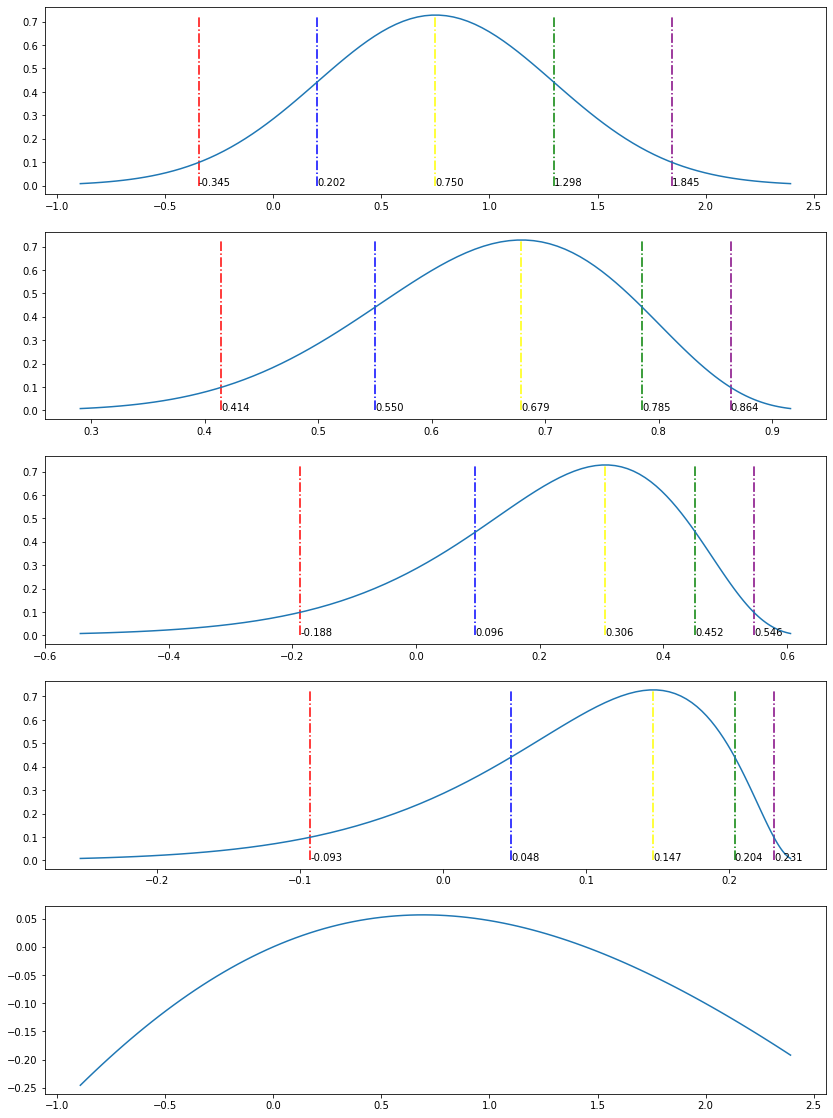

In [13]:
mu = 0.75
variance = 0.3
colours = ['red', 'blue', 'yellow', 'green', 'purple']
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
z = np.linspace(mu-2*sigma, mu+2*sigma, 5)
fig, axs = plt.subplots(5, figsize=(14, 4*5))
axs[0].plot(x, stats.norm.pdf(x, mu, sigma))
axs[0].vlines(z, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(z, zip(z, [0]*5)):
    axs[0].annotate('%.3f'%value, xy=coord)
axs[1].plot(expit(x), stats.norm.pdf(x, mu, sigma))
axs[1].vlines(expit(z), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z), zip(expit(z), [0]*5)):
    axs[1].annotate('%.3f'%value, xy=coord)
axs[2].plot(np.log(expit(x))-np.log(1/2), stats.norm.pdf(x, mu, sigma))
# axs[2].plot(np.log(1/2) - np.log(expit(x)), stats.norm.pdf(x, mu, sigma))
axs[2].vlines(np.log(expit(z))-np.log(1/2), ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(np.log(expit(z))-np.log(1/2), zip(np.log(expit(z))-np.log(1/2), [0]*5)):
    axs[2].annotate('%.3f'%value, xy=coord)
axs[3].plot(expit(x) - (np.square(expit(x)) + np.square(1 - expit(x)))/2 - 0.25, stats.norm.pdf(x, mu, sigma))
axs[3].vlines(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
for value, coord in zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, zip(expit(z) - (np.square(expit(z)) + np.square(1 - expit(z)))/2 - 0.25, [0]*5)):
    axs[3].annotate('%.3f'%value, xy=coord)
actual_pr_ru_rs = analytical_best_report_ru_rs(prior_red, pr_red_ball_red_bucket, pr_red_ball_blue_bucket)
expected_init = expected_log_reward_red_ball(actual_pr_ru_rs, 1/2, prior_red)
expected_z = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(z)), prior_red)
expected_x = expected_log_reward_red_ball(actual_pr_ru_rs, np.array(expit(x)), prior_red)
# axs[4].plot(expected_x-expected_init, stats.norm.pdf(x, mu, sigma))
# axs[4].vlines(expected_z-expected_init, ymin=0, ymax=np.max(stats.norm.pdf(x, mu, sigma)), linestyle='dashdot', colors=colours)
# for value, coord in zip(expected_z-expected_init, zip(expected_z-expected_init, [0]*5)):
#     axs[4].annotate('%.3f'%value, xy=coord)
axs[4].plot(x, expected_x-expected_init)
plt.show()

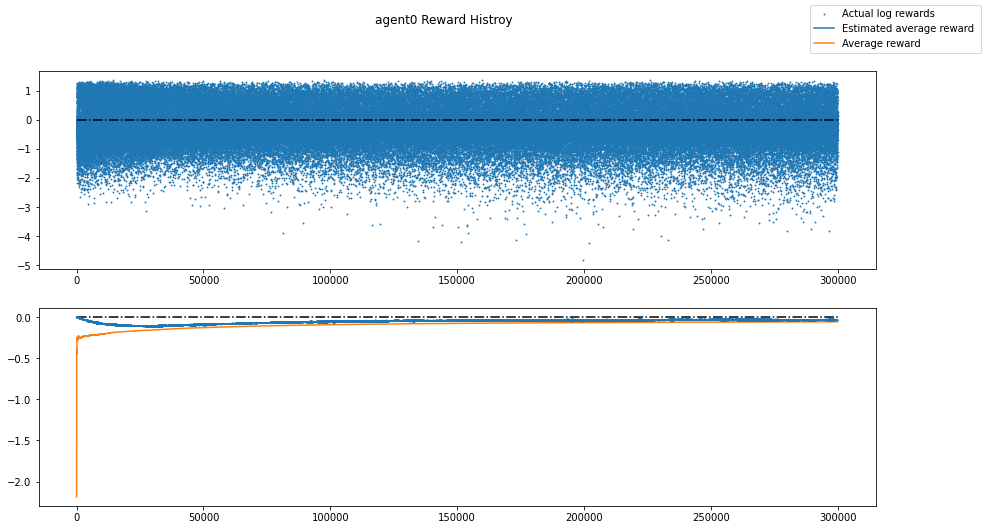

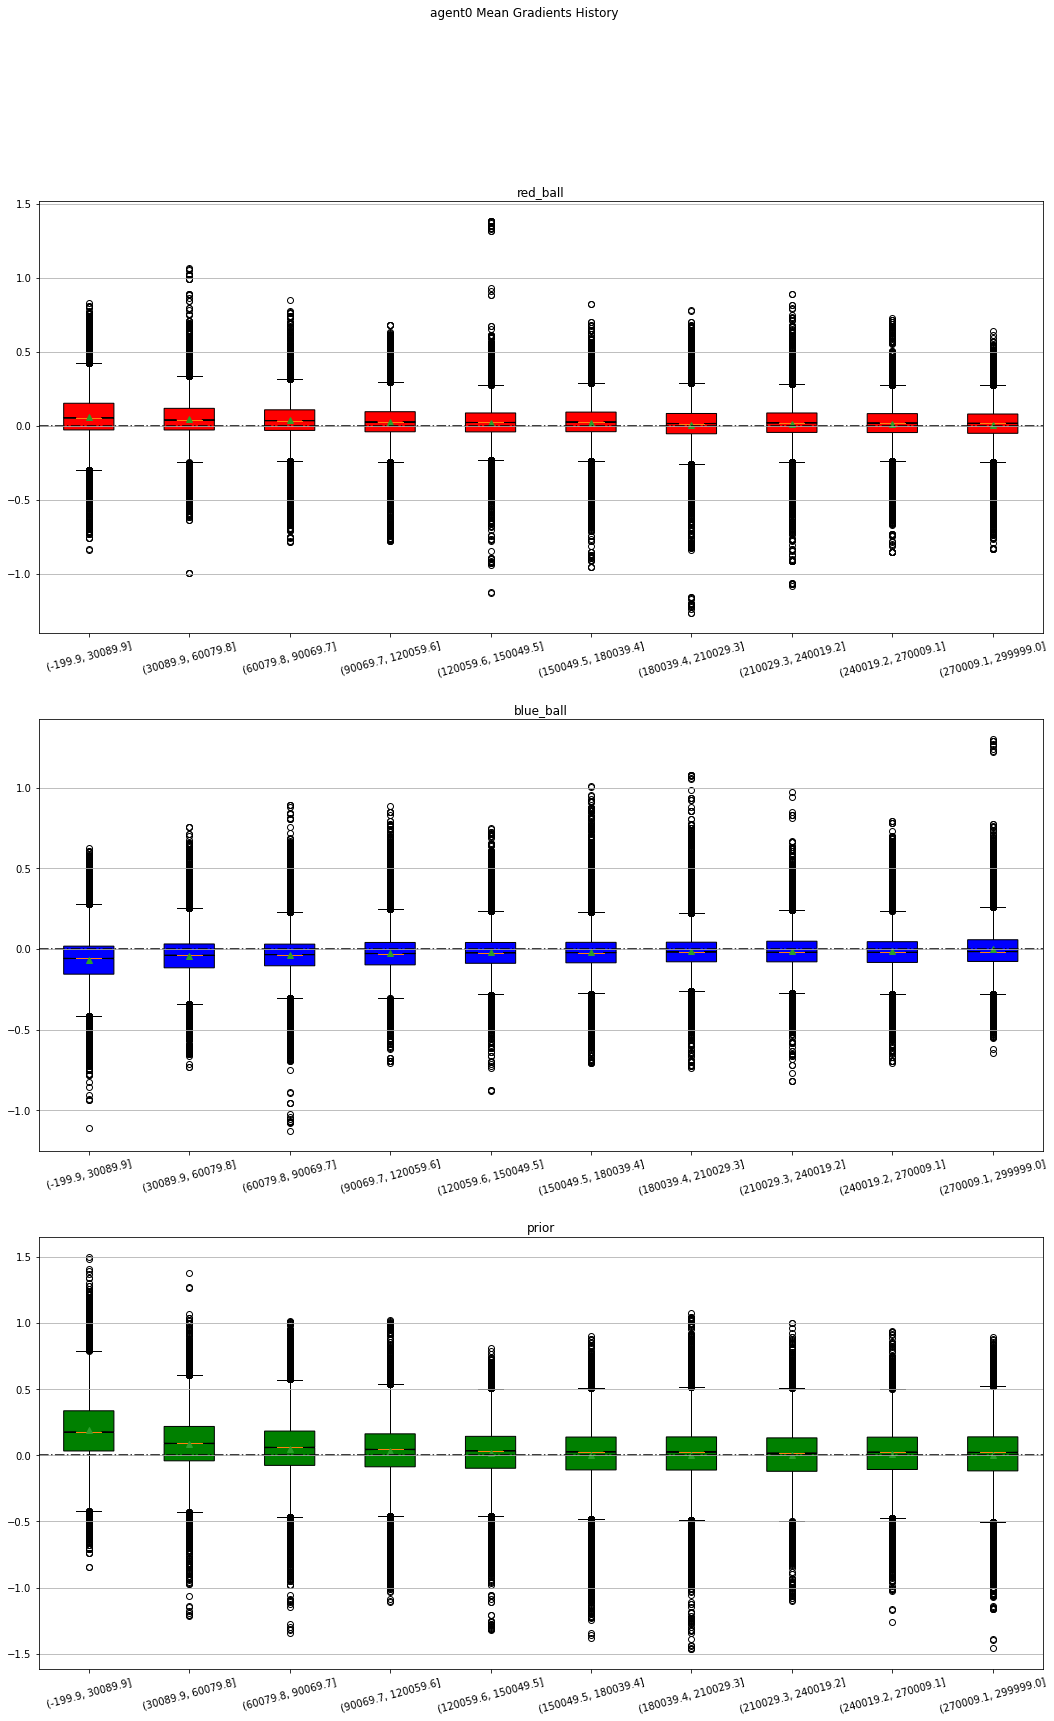

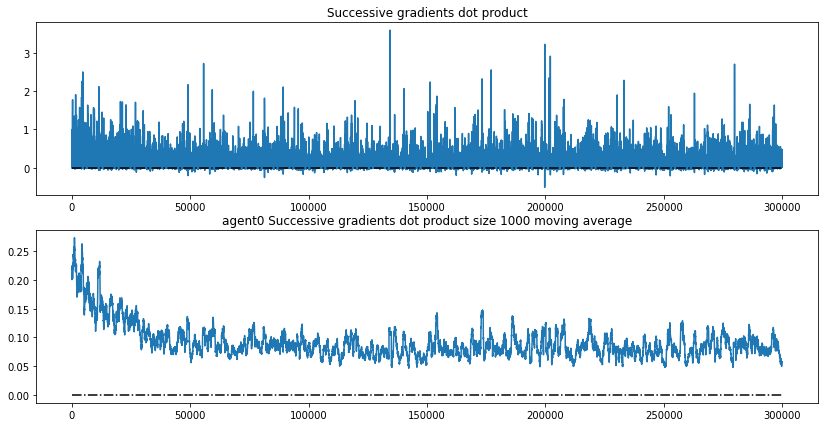

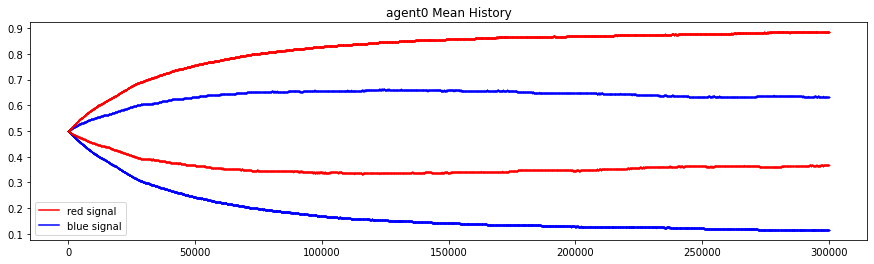

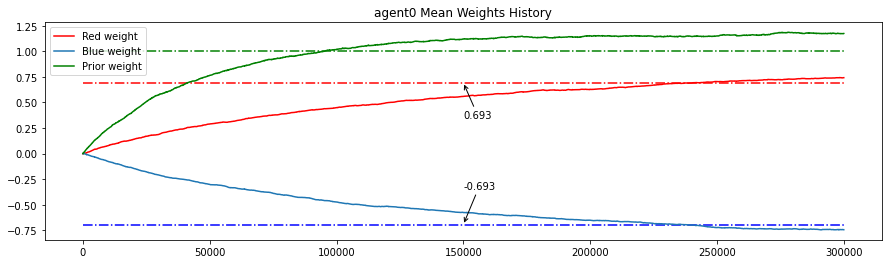

In [7]:
for agent in agent_list:
    agent.reward_history_plot()
#     agent.report_history_plot()
    agent.mean_gradients_history_plot()
    agent.mean_gradients_successive_dot_product_plot()
    agent.mean_history_plot()
    agent.mean_weights_history_plot()

In [8]:
if learning_std:
    min_std = report_history_df['std'].min()
    fig, ax = plt.subplots(figsize=(15, 4))
    for signal, df in report_history_df.reset_index().groupby('signal'):
        ax.scatter(x=df['index'], y=df['std'], label=signal, marker='.', c=signal, s=0.1)
    plt.hlines(y=0, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot')
    plt.hlines(y=min_std, xmin=0, xmax=len(report_history_df) , colors='black', linestyles='dashdot', label=str(min_std))
    red_line = mlines.Line2D([], [], color='red', label='red signal')
    blue_line = mlines.Line2D([], [], color='blue', label='blue signal')
    ax.legend(handles=[red_line, blue_line])
    plt.title('Standard Diviation')
